Text(0.5, 1.0, 'Gyroscope Amplitude for Wrist')

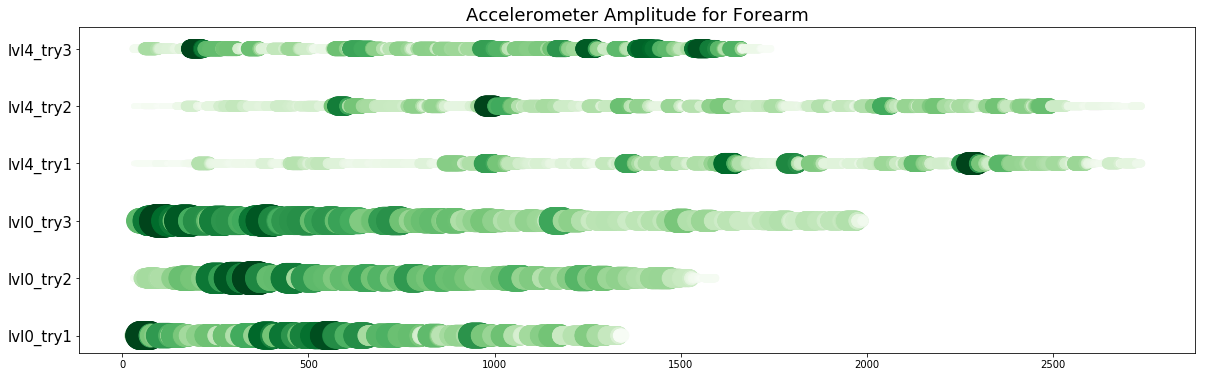

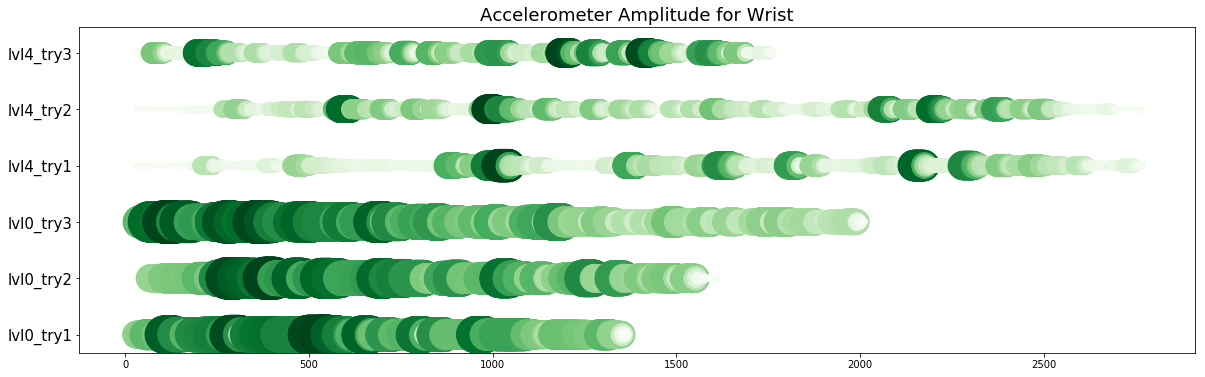

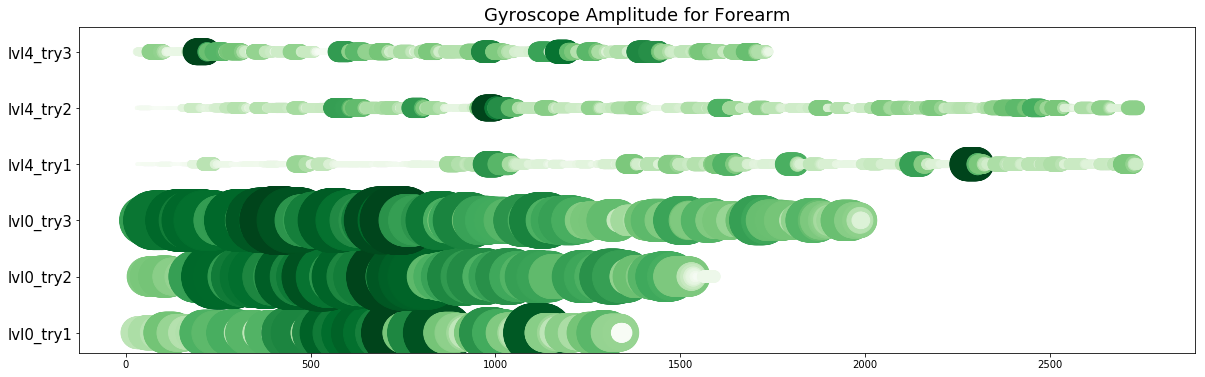

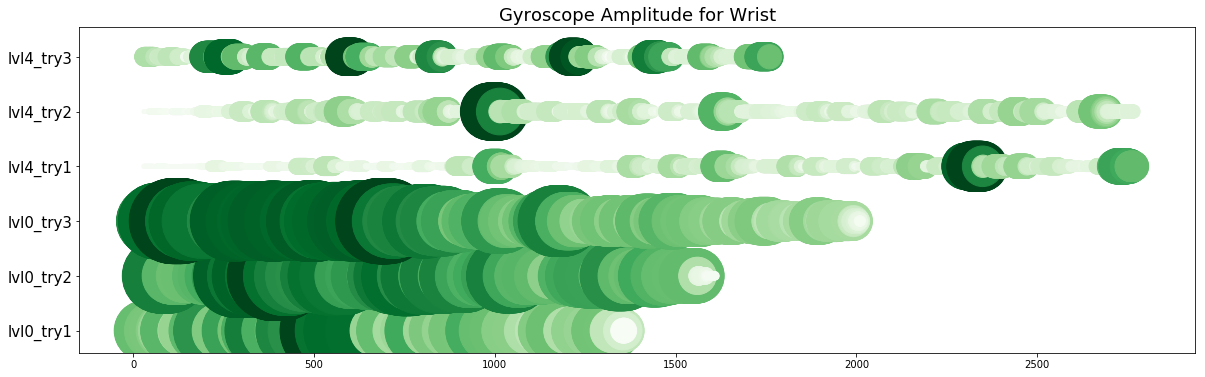

In [67]:
from os import listdir
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

ratio = (20,6)
counter = [0,0,0,0]
fig1, ax1 = plt.subplots(figsize=ratio)
fig2, ax2 = plt.subplots(figsize=ratio)
fig3, ax3 = plt.subplots(figsize=ratio)
fig4, ax4 = plt.subplots(figsize=ratio)

def cal_mean(c):
    # calculate mean of 3 different tries
    return np.around(np.add.reduceat(c, np.arange(0, len(c), 3))/3,3)

def bubble_plot(df):
    return 0

def calculate_stats(path, window, truncate, info):
    dir_ = 'Data/'
    filenames = [filename for filename in listdir(dir_ + path) if filename.endswith('.csv')]
    
    for i in range(len(filenames)):
        file = filenames[i]
        title = file.split('_')[0]

        # extract dataframe
        df = pd.read_csv(dir_ + path + file)

        # combine triaxial data into one singular magnitude data
        if 'Accelerometer' in file:
            df['x'] = df.loc[window-1:,'x-axis (g)']-df['x-axis (g)'].rolling(window).mean()[window-1:]
            df['y'] = df.loc[window-1:,'y-axis (g)']-df['y-axis (g)'].rolling(window).mean()[window-1:]
            df['z'] = df.loc[window-1:,'z-axis (g)']-df['z-axis (g)'].rolling(window).mean()[window-1:]
            df['magnitude'] = df['x']**2 + df['y']**2 + df['z']**2
            df['magnitude'] = (df['magnitude'].apply(math.sqrt))*9.81

        elif 'Gyroscope' in file:
            df['x'] = df.loc[window-1:,'x-axis (deg/s)']-df['x-axis (deg/s)'].rolling(window).mean()[window-1:]
            df['y'] = df.loc[window-1:,'y-axis (deg/s)']-df['x-axis (deg/s)'].rolling(window).mean()[window-1:]
            df['z'] = df.loc[window-1:,'z-axis (deg/s)']-df['x-axis (deg/s)'].rolling(window).mean()[window-1:]
            df['magnitude'] = df['x']**2 + df['y']**2 + df['z']**2
            df['magnitude'] = df['magnitude'].apply(math.sqrt)

        # truncate signal beyond start and end times
        df = df[(df['elapsed (s)'] <= truncate[i][1]) & (df['elapsed (s)'] >= truncate[i][0])]
        df.reset_index(inplace=True)

        # extract umbrella curve
        df['max'] = df['magnitude'].rolling(30).max()
        
        # calculate rolling frequency
        freqs, times, spectrogram = signal.spectrogram(df['magnitude'].values, fs=50.0, nperseg=70, noverlap=70-1)
        df_ = pd.DataFrame({'time':times, 'freq':[freqs[i] for i in np.argmax(spectrogram,0)]})
        df_['max'] = df_['freq'].rolling(30).max()

        # gather information on amplitude
        stats = df.describe().loc[:,['max','magnitude']].T
        # gather information on frequency
        stats_ = df_.describe().loc[:,['max','freq']].T
        
        # append into dataframe
        info = info.append({
            'test': title,
            'mean_amp': stats['mean'][0].round(3),
            'std_amp': stats['std'][1].round(3),
            'mean_freq': stats_['mean'][0].round(3),
            'std_freq': stats_['std'][1].round(3)
        }, ignore_index=True)
        
#         # ONLY UNCOMMENT WHEN PLOTTING INDIVIDUAL GRAPHS
#         # plot magnitude graph
#         ax1=df.plot(x='elapsed (s)',y=['magnitude','max'],grid=True,figsize=(16,5),title=title)
#         ax1.set_xlabel('time (s)')
#         ax1.set_ylabel('amplitude')
#         # plot spectrogram
#         plt.figure(figsize=(16,5))
#         plt.imshow(spectrogram, aspect='auto', cmap='hot_r', origin='lower')
#         plt.title('Spectrogram')
#         plt.ylabel('Frequency band')
#         plt.xlabel('Time window')
#         plt.tight_layout()
#         # plot frequency over time
#         ax2=df_.plot(x='time',y='freq',
#                  grid=True,figsize=(16,5),ylim=[0,15],
#                  title=title)
#         ax2.set_xlabel('time (s)')
#         ax2.set_ylabel('frequency (Hz)')

#         # PLOT BUBBLE GRAPH FOR AMPLITUDE
#         if 'Accelerometer' in file:
#             if 'forearm' in file:
#                 ax1.scatter(df.index[30:],np.ones(len(df.index[30:]))*counter[0],
#                             c=df['max'][30:],cmap="Greens",
#                             s=(df['max'][30:]*2.5**5.5).apply(int))
#                 counter[0]+=1
#             elif 'wrist' in file:
#                 ax2.scatter(df.index[30:],np.ones(len(df.index[30:]))*counter[1],
#                             c=df['max'][30:],cmap="Greens",
#                             s=(df['max'][30:]*2.5**5.5).apply(int))
#                 counter[1]+=1
#         elif 'Gyroscope' in file:
#             if 'forearm' in file:
#                 ax3.scatter(df.index[30:],np.ones(len(df.index[30:]))*counter[2],
#                             c=df['max'][30:],cmap="Greens",
#                             s=(df['max'][30:]**1.7).apply(int))
#                 counter[2]+=1
#             elif 'wrist' in file:
#                 ax4.scatter(df.index[30:],np.ones(len(df.index[30:]))*counter[3],
#                             c=df['max'][30:],cmap="Greens",
#                             s=(df['max'][30:]**1.7).apply(int))
#                 counter[3]+=1
        
#         # PLOT BUBBLE GRAPH FOR FREQUENCY
#         if 'Accelerometer' in file:
#             if 'forearm' in file:
#                 ax1.scatter(df_['time'][30:],np.ones(len(df_.index[30:]))*counter[0],
#                             c=df_['max'][30:],cmap="Greens",
#                             s=(df_['max'][30:]**2.3).apply(int))
#                 counter[0]+=1
#             elif 'wrist' in file:
#                 ax2.scatter(df_['time'][30:],np.ones(len(df_.index[30:]))*counter[1],
#                             c=df_['max'][30:],cmap="Greens",
#                             s=(df_['max'][30:]**2.3).apply(int))
#                 counter[1]+=1
#         elif 'Gyroscope' in file:
#             if 'forearm' in file:
#                 ax3.scatter(df_['time'][30:],np.ones(len(df_.index[30:]))*counter[2],
#                             c=df_['max'][30:],cmap="Greens",
#                             s=(df_['max'][30:]**2.3).apply(int))
#                 counter[2]+=1
#             elif 'wrist' in file:
#                 ax4.scatter(df_['time'][30:],np.ones(len(df_.index[30:]))*counter[3],
#                             c=df_['max'][30:],cmap="Greens",
#                             s=(df_['max'][30:]**2.3).apply(int))
#                 counter[3]+=1
        
    return info


info = pd.DataFrame(columns=['test','mean','std'])

# HANDGRIP
truncate = [(80,107),(80,107),(12.5,39.5),(12.5,39.5),(10,42),(10,42),(46,78),(46,78),(52,92),(52,92),(30,70),(30,70),
            (50,105),(50,105),(14,69),(14,69),(13,68),(13,68),(70,125),(70,125),(33.5,68.5),(33.5,68.5),(5,40),(5,40)]
info = calculate_stats('handgrip_experiment/', 3, truncate, info)

# PRONATION AND SUPINATION
truncate = [(127.5,160),(127.5,160),(196,229),(196,229),(48.5,80),(48.5,80),(17.5,50),(17.5,50),(15,51),(15,51),(50,86),(50,86),
            (44,80),(44,80),(63,101),(63,101),(9,48),(9,48),(27,65),(27,65),(10,60),(10,60),(60,107),(60,107)]
info = calculate_stats('pronationsupination_experiment/', 3, truncate, info)

# ax1.yaxis.set_ticks(np.arange(0,6,1))
# ax1.set_yticklabels(np.array(['lvl0_try1','lvl0_try2','lvl0_try3','lvl4_try1','lvl4_try2','lvl4_try3']), fontdict={'fontsize':15})

# ax2.yaxis.set_ticks(np.arange(0,6,1))
# ax2.set_yticklabels(np.array(['lvl0_try1','lvl0_try2','lvl0_try3','lvl4_try1','lvl4_try2','lvl4_try3']), fontdict={'fontsize':15})

# ax3.yaxis.set_ticks(np.arange(0,6,1))
# ax3.set_yticklabels(np.array(['lvl0_try1','lvl0_try2','lvl0_try3','lvl4_try1','lvl4_try2','lvl4_try3']), fontdict={'fontsize':15})

# ax4.yaxis.set_ticks(np.arange(0,6,1))
# ax4.set_yticklabels(np.array(['lvl0_try1','lvl0_try2','lvl0_try3','lvl4_try1','lvl4_try2','lvl4_try3']), fontdict={'fontsize':15})

# ax1.set_title('Accelerometer Amplitude for Forearm', {'fontsize': 18})
# ax2.set_title('Accelerometer Amplitude for Wrist', {'fontsize': 18})
# ax3.set_title('Gyroscope Amplitude for Forearm', {'fontsize': 18})
# ax4.set_title('Gyroscope Amplitude for Wrist', {'fontsize': 18})

In [43]:
# REARRANGE DATAFRAME
info['name'] = info['test'].apply(lambda x:x.split('-')[0])
info['level'] = info['test'].apply(lambda x:x.split('-')[1])
info['try'] = info['test'].apply(lambda x:x.split('-')[2])

info = pd.DataFrame({'name': info['name'].iloc[::2].values,
                     'level': info['level'].iloc[::2].apply(lambda x:int(x[-1])).values,
                     'try': info['try'].iloc[::2].apply(lambda x:int(x[-1])).values,
                     'mean_accel_amp': info['mean_amp'].iloc[::2].values,
                     'mean_gyro_amp': info['mean_amp'].iloc[1::2].values,
                     'std_accel_amp': info['std_amp'].iloc[::2].values,
                     'std_gyro_amp': info['std_amp'].iloc[1::2].values,
                     'mean_accel_freq': info['mean_freq'].iloc[::2].values,
                     'mean_gyro_freq': info['mean_freq'].iloc[1::2].values,
                     'std_accel_freq': info['std_freq'].iloc[::2].values,
                     'std_gyro_freq': info['std_freq'].iloc[1::2].values})

info = pd.DataFrame({'name': info['name'].iloc[::6].values,
                     'level': info['level'].iloc[::6].values,
                     'mean_acc_forearm_amp': cal_mean(info['mean_accel_amp'].iloc[::2].values),
                     'mean_acc_wrist_amp': cal_mean(info['mean_accel_amp'].iloc[1::2].values),
                     'mean_gyr_forearm_amp': cal_mean(info['mean_gyro_amp'].iloc[::2].values),
                     'mean_gyr_wrist_amp': cal_mean(info['mean_gyro_amp'].iloc[1::2].values),
                     'std_acc_forearm_amp': cal_mean(info['std_accel_amp'].iloc[::2].values),
                     'std_acc_wrist_amp': cal_mean(info['std_accel_amp'].iloc[1::2].values),
                     'std_gyr_forearm_amp': cal_mean(info['std_gyro_amp'].iloc[::2].values),
                     'std_gyr_wrist_amp': cal_mean(info['std_gyro_amp'].iloc[1::2].values),
                     'mean_acc_forearm_freq': cal_mean(info['mean_accel_freq'].iloc[::2].values),
                     'mean_acc_wrist_freq': cal_mean(info['mean_accel_freq'].iloc[1::2].values),
                     'mean_gyr_forearm_freq': cal_mean(info['mean_gyro_freq'].iloc[::2].values),
                     'mean_gyr_wrist_freq': cal_mean(info['mean_gyro_freq'].iloc[1::2].values),
                     'std_acc_forearm_freq': cal_mean(info['std_accel_freq'].iloc[::2].values),
                     'std_acc_wrist_freq': cal_mean(info['std_accel_freq'].iloc[1::2].values),
                     'std_gyr_forearm_freq': cal_mean(info['std_gyro_freq'].iloc[::2].values),
                     'std_gyr_wrist_freq': cal_mean(info['std_gyro_freq'].iloc[1::2].values)})

info.T

,0,1
name,hgrip,hgrip
level,0,4
mean_acc_forearm_amp,3.283,0.894
mean_acc_wrist_amp,6.748,1.865
mean_gyr_forearm_amp,91.84,17.809
mean_gyr_wrist_amp,124.69,28.179
std_acc_forearm_amp,0.923,0.315
std_acc_wrist_amp,1.796,0.713
std_gyr_forearm_amp,21.264,5.397
std_gyr_wrist_amp,31.271,9.03
